# Fine-Tuning a Pretrained Transformer (KerasHub + HuggingFace)

# Setup and Installations

In [ ]:
# Setup and Installations
!pip install -q transformers keras-hub datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5

# Imports and Initialization

In [ ]:
# Imports and Initialization
import os
import keras
import keras_hub
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding,
                          TrainingArguments, Trainer, pipeline)
import evaluate

In [ ]:
# Set random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Set Keras backend
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

# 📜 PART 1: Fine-tuning with KerasHub TextClassifier (IMDB Dataset)

In [ ]:
print("\nLoading IMDB dataset for KerasHub fine-tuning...")
extract_dir = keras.utils.get_file(
    "imdb_reviews",
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract=True,
)

# The extracted data is directly within 'aclImdb', not under '.keras/datasets/aclImdb'
data_dir = os.path.join(extract_dir, "aclImdb")
# Now data_dir should point to /root/.keras/datasets/imdb_reviews/aclImdb

raw_train_ds = keras.utils.text_dataset_from_directory(
    os.path.join(data_dir, "train"),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=seed,
)
raw_val_ds = keras.utils.text_dataset_from_directory(
    os.path.join(data_dir, "train"),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)




Loading IMDB dataset for KerasHub fine-tuning...
Found 75000 files belonging to 3 classes.
Using 60000 files for training.
Found 75000 files belonging to 3 classes.
Using 15000 files for validation.


In [ ]:
print("\nLoading TextClassifier from keras_hub...")
classifier = keras_hub.models.TextClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=2,
)

classifier.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(5e-5),
    metrics=["accuracy"],
)

print("\nStarting fine-tuning...")
history = classifier.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    epochs=3,
)


Loading TextClassifier from keras_hub...


100%|██████████| 507/507 [00:00<00:00, 715kB/s]



Starting fine-tuning...
Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 97s 43ms/step - accuracy: 0.1655 - loss: nan - val_accuracy: 0.1681 - val_loss: nan
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 131s 42ms/step - accuracy: 0.1650 - loss: nan - val_accuracy: 0.1681 - val_loss: nan
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.1651 - loss: nan - val_accuracy: 0.1681 - val_loss: nan


# Plot training curves

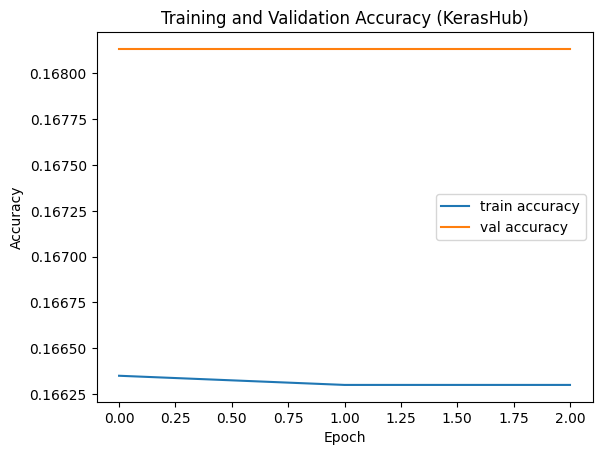

In [ ]:
# Plot training curves
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy (KerasHub)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 📜 PART 2: Fine-tuning with HuggingFace Trainer (Rotten Tomatoes Dataset)

In [ ]:
!pip install --upgrade transformers

In [ ]:
print("\nLoading Rotten Tomatoes dataset...")
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

print("\nLoading Hugging Face BERT-base model and tokenizer...")
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)


Loading Rotten Tomatoes dataset...

Loading Hugging Face BERT-base model and tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenize dataset

In [ ]:
# Tokenize dataset
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

# Define evaluation metric

In [ ]:
# Define evaluation metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_metric = evaluate.load("f1")
    return {"f1": f1_metric.compute(predictions=predictions, references=labels)["f1"]}

# Training arguments

In [ ]:
# Training arguments
training_args = TrainingArguments(
    "finetuned-bert-rotten-tomatoes",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    # Replace 'evaluation_strategy' with 'eval_strategy'
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    report_to="none",
)

# Trainer setup

In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\nStarting Hugging Face fine-tuning...")
trainer.train()


<ipython-input-16-5319bd8467ee>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting Hugging Face fine-tuning...


Epoch,Training Loss,Validation Loss,F1
1,0.348300,0.373769,0.848754
2,0.155300,0.428507,0.847619


TrainOutput(global_step=1068, training_loss=0.31367139021555585, metrics={'train_runtime': 245.5938, 'train_samples_per_second': 69.464, 'train_steps_per_second': 4.349, 'total_flos': 455129709117240.0, 'train_loss': 0.31367139021555585, 'epoch': 2.0})

# Evaluate

In [ ]:
# Evaluate
print("\nEvaluation Results:")
metrics = trainer.evaluate()
print(metrics)


Evaluation Results:


{'eval_loss': 0.4285067617893219, 'eval_f1': 0.8476190476190476, 'eval_runtime': 4.6419, 'eval_samples_per_second': 229.647, 'eval_steps_per_second': 14.434, 'epoch': 2.0}


# Evaluation Summary Visualization

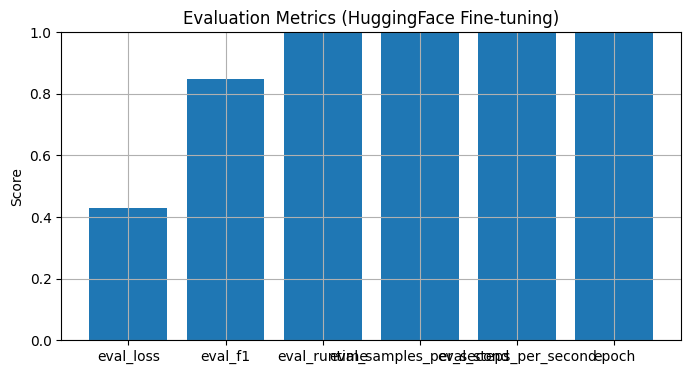

In [ ]:
# Visualization: Evaluation Summary

labels = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(8, 4))
plt.bar(labels, values)
plt.title('Evaluation Metrics (HuggingFace Fine-tuning)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.show()